# Build a Traffic Sign Recognition Classifier

---
## Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s).

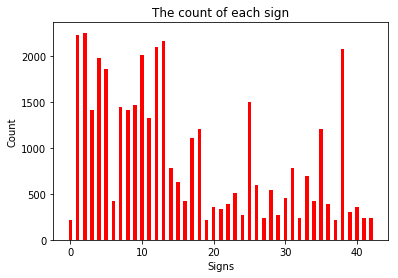

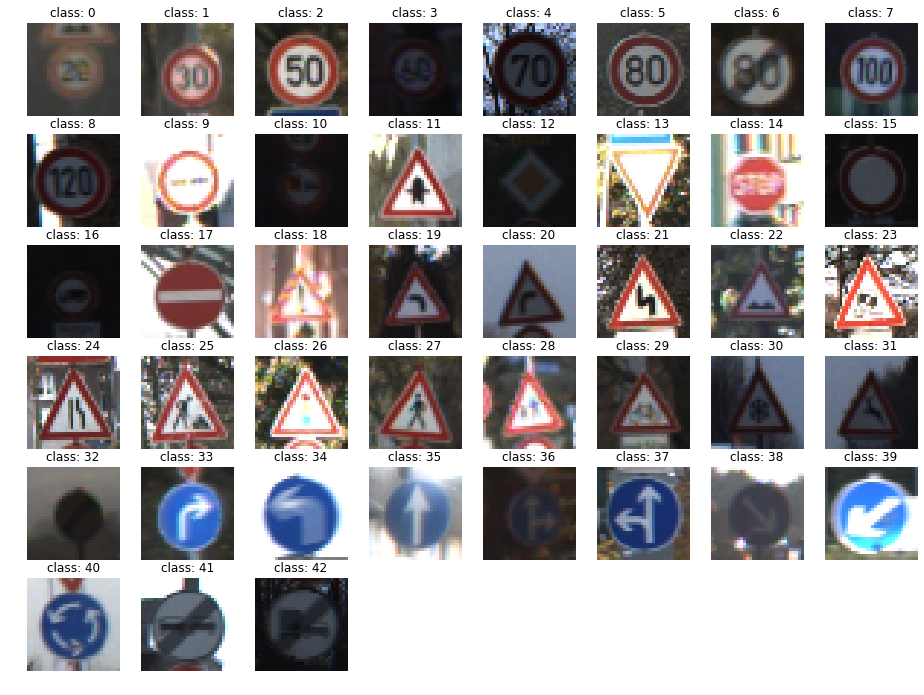

In [3]:
### Data exploration visualization.
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

## Design and Test a Baseline Model Architecture

### Custom Dataset

In [4]:
import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [5]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1)

### Baseline Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 43)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

n_epochs = 1
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0
    accuracy = 0
    
    # Train model
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device, dtype=torch.int64)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    
    # Validate model
    model.eval()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device, dtype=torch.int64)
        output = model(x)
        loss = criterion(output, y)
        valid_loss += loss.item() * x.size(0)
        # accuracy
        pred = torch.argmax(output, dim=1)
        correct = pred == y.view(*pred.shape)
        accuracy += torch.sum(correct).item()
    
    # Caculate loss and accuracy
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(test_loader.dataset)
    accuracy = accuracy / len(test_loader.dataset) * 100
    
    # Print loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.3f}%'.format(epoch, train_loss, valid_loss, accuracy))

Epoch: 1 	Training Loss: 2.676190 	Validation Loss: 1.619382 	Validation Accuracy: 50.665%


## TODO
1. image normalize
2. imbalance dataset -> weighted sampler
3. data augmentation
3. clahe
4. transfer learning or new model
5. spatial transformer network